# Mermin Peres Magic Square Game

The Mermin Peres Magic Square Game is a Game that is not solvable with a probability of 100% on classical computers. It operates in the following manner: Two players, Alice and Bob, play a cooperative game, yet unable to communicat by playing in a respectivly randomly assigned column / row either +1 or -1. The game is won if the number of +1 played in the selcted column is even and the -1 played in the rows is odd, further and crucially, the intersecting cell between column and row must be the same. As illustrated in the image below there is no classical solution to win the game with probability of 100%, however, the game can be won with a probability of 88,89%

<img src="Mirmin-Peres-Game/MPG.png" width="400">


However, in order to solve this game with a probility of 100%, one might look in the direction of quantum mechanics, quantum computing and quantum pseudo-telepathy where superposition and entanglement have already solved problems unfeasible on classical systems. Then, to realise this feat the Python Qiskit framework was employed, [extended from this Medium atricle] (https://medium.com/qiskit/this-proof-demonstrates-a-quantum-advantage-even-for-noisy-quantum-computers-b44a738801ad). Subsequently, this notebook will introduce the quantum circuit solving the MPG game,  provide a step-by-step walkthrough of the mathematical operation applied during an exemplary game and quantify it's performance on both simulated and real quantum computers.


First, for the subsequent circuit definition, evaluation and illustration, we first have to define auxiliary functions and import the corresponding modules from Qiskit and Numpy

In [1]:
from qiskit import *
import numpy as np
from qiskit.test.mock import *
from qiskit.visualization import plot_state_qsphere


In [212]:
#checks if the circuit output fulfills the winning criteria
def check_result(results, col, row):
    
    print_tut = True
    expected_states = []
    
    for i in results: 
        
        #if print_tut:
        #    explain(i, col, row)
        #    print_tut = False

        #print("Quantum circuit solution")
        #print(i+"\n")
    
        i_orginal = i
        i = np.array(list(i.replace(" ", "")), dtype=np.int32)[::-1]
        
        # bring array in correct i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2
        a = i[0:2]
        a_sum = np.sum(a)
        a3 = int(np.mod(a_sum+1,2))
        a = np.append(a,a3)
        winning_alice = np.mod(a_sum + a3, 2) == 1
        # compute x3 by x1+x2+1 mod 2 and save to array

        b = i[2:]
        b_sum = np.sum(b)
        b3 = int(np.mod(b_sum,2))
        b = np.append(b,b3)
        winning_bob = np.mod(b_sum + b3, 2) == 0   
        # compute y3 by y1+y2 mod 2 and save to array

        # compute overall winning condition -> alice at index of bob's row and vice versa
        #print("Alice's selection. Column:"+str(col)+"\n"+str(a.reshape(3,1))+"\n")
        #print("Bob's circuit solution. Row:"+str(row)+"\n"+str(b)+"\n")
        
        if(winning_bob & winning_alice & (a[row-1]==b[col-1])):
            #print("Victory!")    
            #print("The following magic square wins the game!")

            expected_states.append(str(i_orginal))
            k = np.empty((3,3,))
            k[:] = np.nan
            k[:,col-1] = a
            k[row-1,:] = b
            #print(k)

        #print("------------------------------------------")  
        #print("\n")
    return expected_states

In [213]:
# function explaining the computation of x3, y3 and presenting the corresponding winning moves
def explain(result, col, row):
    print("Resultant quantum circuit solution:"+"\n")
    print(result+"\n")
    example = np.array(list(result.split())).astype(int)[::-1]
    print("Bring array in correct bit order i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2"+"\n")
    print(str(example)+"\n")
    print("Compute missing x3 with x1+x2+1 mod 2 for Alice and save to array for further processing")
    print("Compute missing y3 with y1+y2 mod 2 for Bob and save to array for further processing"+"\n")
   
    a = example[0:2]
    a_sum = np.sum(a)
    a3 = int(np.mod(a_sum+1,2))
    a = np.append(a,a3)
    winning_alice = np.mod(a_sum + a3, 2) == 1

    b = example[2:]
    b_sum = np.sum(b)
    b3 = int(np.mod(b_sum,2))
    b = np.append(b,b3)
    winning_bob = np.mod(b_sum + b3, 2) == 0   

    print("Alice's column solution"+"\n"+str(a.reshape(3,1))+"\n" + "Winning conditions fullfilled (Odd quantitude of 1)?: "+str(winning_alice)+"\n")
    print("Bob's row solution"+"\n"+str(b)+"\n"+ "Winning conditions fullfilled (Even quantitude of 1)?: "+str(winning_bob)+"\n")
    print("Create matrix to show results"+"\n")
    k = np.empty((3,3,))
    k[:] = np.nan
    k[:,col-1] = a
    k[row-1,:] = b
    print(k)
    print("------------------------------------------")  
    print("------------------------------------------")  

In [214]:
# function to calculate state accuracy
def get_state_accuracy(counts, expected_states, shots): 
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [215]:
# function that sets up the initial entanglement between Alice and Bob
def share_bell_state(qc,a,b,c,d): 
    qc.h(a)
    qc.h(b)
    qc.cx(a,c)
    qc.cx(b,d)
    
# The following functions represent the U(gamma) and V(gamma) controlled Cliffords.
def U(qc,gamma,a,b):
    if gamma==1:
        qc.h(a)
        qc.i(b)

    elif gamma==2:
        qc.swap(a,b)
        qc.h(a)
        qc.i(b)

    elif gamma==3:
        qc.cx(a,b)
        qc.h(a)
        qc.i(b)

def V(qc,gamma,a,b):
    if gamma==1:
        qc.h(a)
        qc.h(b)

    if gamma==2:
        qc.swap(a,b)

    elif gamma==3:
        qc.z(a)
        qc.z(b)
        qc.cz(a,b)
        qc.h(a)
        qc.h(b)

In [211]:
#We will ask the user to select the row and column on Alice and Bob's behalf.
print("Alice and Bob, select a column or row value of 1, 2, or 3") 
print("Alice choice (column):")
alpha = int(input())
print("Bob choice (row):")
beta = int(input())

#Create the quantum register and the classical register to store our final bit values
aliceQR = QuantumRegister(2)
x1CR = ClassicalRegister(1)
x2CR = ClassicalRegister(1)
bobQR = QuantumRegister(2)
y1CR = ClassicalRegister(1)
y2CR = ClassicalRegister(1)

#Create the circuit
magicsquare_circuit = QuantumCircuit(aliceQR,bobQR,x1CR,x2CR,y1CR,y2CR)

#Generate the Bell state on the circuit
share_bell_state(magicsquare_circuit,0,1,2,3)

magicsquare_circuit.barrier()

#Draw the rest of the circuit based on Alice and Bob's selection   
if 4>alpha>0 and 4>beta>0:
    U(magicsquare_circuit,alpha,0,1) 
    V(magicsquare_circuit,beta,2,3)
    magicsquare_circuit.barrier()
    magicsquare_circuit.measure(0,0)
    magicsquare_circuit.measure(1,1)
    magicsquare_circuit.measure(2,2)
    magicsquare_circuit.measure(3,3)
    
    magicsquare_circuit.draw(output='mpl')
    print(magicsquare_circuit)    

    job = execute(magicsquare_circuit, BasicAer.get_backend('qasm_simulator'), optimization_level=3, shots=8192) # run the job simulation
    results = job.result().get_counts()
    expected_states = check_result(results, alpha, beta)
    state_accuracy = get_state_accuracy(results,expected_states,8192)
    print(state_accuracy)

else:
    print("please enter values of 1, 2, or 3")

Alice and Bob, select a column or row value of 1, 2, or 3
Alice choice (column):
Bob choice (row):
         ┌───┐           ░      ┌───┐ ░ ┌─┐         
q1120_0: ┤ H ├──■────────░───X──┤ H ├─░─┤M├─────────
         ├───┤  │        ░   │  ├───┤ ░ └╥┘┌─┐      
q1120_1: ┤ H ├──┼────■───░───X──┤ I ├─░──╫─┤M├──────
         └───┘┌─┴─┐  │   ░ ┌───┐└───┘ ░  ║ └╥┘┌─┐   
q1121_0: ─────┤ X ├──┼───░─┤ H ├──────░──╫──╫─┤M├───
              └───┘┌─┴─┐ ░ ├───┤      ░  ║  ║ └╥┘┌─┐
q1121_1: ──────────┤ X ├─░─┤ H ├──────░──╫──╫──╫─┤M├
                   └───┘ ░ └───┘      ░  ║  ║  ║ └╥┘
 c159: 1/════════════════════════════════╩══╬══╬══╬═
                                         0  ║  ║  ║ 
                                            ║  ║  ║ 
 c160: 1/═══════════════════════════════════╩══╬══╬═
                                            0  ║  ║ 
                                               ║  ║ 
 c161: 1/══════════════════════════════════════╩══╬═
                                               0  ║ 


#### Indeed, using an ideal quantum simulator, a winning probability of 100% is achieved, which exceeds the highest classical winning probability of 88.99% Beyond that, however, it is desirable to quantify the results on a real IBM quantum computer, which will be realized in the last section.

# Mathmatical background of the computation

As we have demonstrated above, the quantum circuit solves the Mirmin-Peres game (MPG) on real quantum computers with a higher probability than with any classical strategy on ordinary computers. To shed some light on how and why this works, we present and explain the mathematical operations that lead to the solution of this game. In particular, we will first present a high-level equation describing the mathematical rationale and then we will take a look at each element of this equation explain it step by step.


Recall that the quantum circuit has to play different moves for each different row/column instances of the MPG being selected, since there is no classical strategy that can win the game with probability = 1. Thus, to win with probability 1, the quantum circuit dynamically adapts to the input of each column and row played. Nevertheless, there is indeed one part of the circuit that remains static and is responsible for generating a matching qubit state and we will start of by focusing on that part. 

The following Pauli operators govern what the ideal mathmatical operations, with the winning criteria in mind, are in correspondace to the selected row and column. 

![title](Mirmin-Peres-Game/Pauli_Operators.png)


These operators can then be translated into the following quantum gates for the respective row / column selected. To further understand why these Pauli operators are translated to the gates, see.: [Quantum advantage in noisy flat circuits](https://arxiv.org/pdf/1904.01502.pdf) 

![title](Mirmin-Peres-Game/Circuit_Operations.png)




Abstractly, then, as evident from the gates and the circuit above, see (a) & (b), the elements can be described by the following high-level formula:

$$ Quantum Solution MPG = Initial Vector * Dynamic Matrix(row, column)$$

#### Starting with the first part of the equation, the intial vector, of the MPG circuit is defined by quantum gates as follows:


In [ ]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
qc.h(q[0])
qc.h(q[1])
qc.cx(q[0],q[2])
qc.cx(q[1],q[3])
#qc.barrier()
qc.draw(output='mpl')


#### The very starting vector state of the MPG circuit, prior to any quantum gate interaction, corresponds to the Dirac bracket |0000> and is hence described by the following vector: 
$$ InitialQubits= \frac 1 {\sqrt{2}} {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}$$

#### In terms of the gates, these are the mathmatical represetations of the relevant gates illustrated above:

$$
I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}  
$$

$$
H = \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

$$
CNOT_{(i, i+2)} = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
\end{pmatrix}
$$

#### While the static matrix, represented as the quantum gates in the illustration above, is created by the appliance of two CNOT gates to the first and third qubit and the second and fourth qubit, as well as two Hadamard gates applied to the first and second qubit. Mathematically, this is described by the following equation: 

$$ Initial Vector = (I ⨂ CNOT_{0|2}) ⨂ (CNOT_{1|3} ⨂ I) * (I ⨂ I ⨂ H ⨂ H) * InitialQubits $$

Subsequently inserting the corresponding matrices into this equation results in the following matrix:

$$
Inital Vector = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} *
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} 
*
\frac 1 {\sqrt{2}} {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$ 
Inital Vector = \begin{bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\ ⨂ \begin {bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1 \end{pmatrix} 

⨂ 

\frac 1 {2} \begin{pmatrix} 1 & 1 & 1 & 1\\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1\\ 1 & -1 & -1 & 1 \end{pmatrix}
*
\frac 1 {\sqrt{2}} {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$ 
InitialVector = \begin{bmatrix}\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
\begin{bmatrix}\ \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}& 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} \\\end{bmatrix}\
*
\frac 1 {\sqrt{2}} {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$

$$
=\begin{bmatrix}\ \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2}& 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2}  \\\ \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & \frac 1 {2} & \frac 1 {2}  \\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0  \\\ 0 & 0 & 0 & 0 & \frac 1 {2} & \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\ \frac 1 {2} & -\frac 1 {2} & -\frac 1 {2} & \frac 1 {2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\\end{bmatrix}\
*
\frac 1 {\sqrt{2}} {\begin{pmatrix} 1 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\0 \\ 0\end{pmatrix}}
$$
$$
= \begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\ 0\\ \frac 1 {2}\end{pmatrix}
$$

#### This vector holds the relevant qubits that can be further considered and modified in the dynmaic part of the circuit so that valid winning can be created, these Qubit states are:
$$= \frac 1 {2} (|0000\rangle+|0101\rangle+|1010\rangle+|1111\rangle)$$


#### Furthermore, when analyzing the initial vector, it becomes apparent that when multiplying any matrix by it, only four relevenate cells per row in the multiplier remain open for consideration, since the others are all multiplied by 0 and thereby likewise drop of with 0% probability as a result. Thus, we can eliminate the majority of the entries whatsoever. As an example we have prepared the matrix below, and denoted all entries with an i, that have to be computed and all others that result in any case with 0 with -.

$$ = 
\begin{bmatrix}\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\ \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i} & - & - & - & - & \color{red}{i}  \\\end{bmatrix} 
*
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$

Let us now take a look at an concrete example, which show and proof that only the i-rows are relevant for the subsequent computation:

$$
Winnning Plays= 
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 \end{bmatrix} * 
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$

Multiplying each row element with each coloumn element yields the following results:

$$
= \frac 1 {\sqrt{8}}
$$


However, considering only the i-row entries yields precisely the same results:
$$
Winnning Plays= 
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & - & - & - & - & \frac 1 {\sqrt{8}}& - & - & - & - & 0 & - & - & - & - & 0 \end{bmatrix} * 
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\ \frac 1 {2}\end{pmatrix}
$$
$$
= \frac 1 {\sqrt{8}}
$$
#### And indeed, this idea is very powerful because it lets us visually see what outcomes may emerge as well asa better idea of which outcomes may fall off and which may be a win in the MPG. As long as postive result emerges the MPG is won, no matter the probability of that play occuring

### Now, in order to consider the later, dynamic, part of the equation we will have to select an example. In this case we have selected row: 1 and column: 1. The corresponding quantum circuit is as follows:

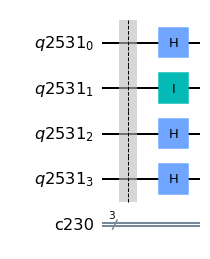

In [439]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
#qc.h(q[0])
#qc.h(q[1])
#qc.cx(q[1],q[3])
#qc.cx(q[0],q[2])
qc.barrier()
qc.h(q[0])
qc.id(q[1])
qc.h(q[2])
qc.h(q[3])
qc.draw(output='mpl')

#### The translation of these circuit gate operations is in turn equivalent to the following mathematical matrice multiplications:
$$ DynamicMatrix(1, 1) = H ⨂ H ⨂ I ⨂ H $$
$$
= \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} ⨂ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} ⨂ \frac 1 {\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$
$$
=
\begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  \\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
\\\
 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
\\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}   
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} 
\\\
 \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\
 \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}
 \\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
 \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} \\\end{bmatrix}\ 
$$

#### Now, as we have both, the inital vector and the dynamic matrix, we can compute the winning plays for Alice and Bob with selected column and row of 1. In prinicple we can apply the rule of the i-rows, that we have established above, to this matrix-vector multiplication, however, in this case for the sake of completness we let all entries remain. But feel free to check the rule!

$$
Winning Plays = DynamicMatrix * InitialVector
$$
$$
= \begin{bmatrix}\ \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  \\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
\\\
 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
\\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}   
\\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} 
\\\
 \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\
 \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} 
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}
 \\\ 
\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0  
\\\ 
\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}& 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0
  \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  
 \\\ 
0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}}  & 0 & 0 & -\frac 1 {\sqrt{8}} & \frac 1 {\sqrt{8}} & 0 & 0 & \frac 1 {\sqrt{8}} & -\frac 1 {\sqrt{8}} \\\end{bmatrix}\ 
*
\begin{pmatrix} \frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\0 \\\frac 1 {2} \\0 \\0 \\0 \\ 0\\ \frac 1 {2}\end{pmatrix}
$$
$$
= \begin{pmatrix} \frac 1 {\sqrt{8}} \\0 \\\frac 1 {\sqrt{8}} \\0 \\0 \\\frac 1 {\sqrt{8}}  \\0 \\\frac 1 {\sqrt{8}}  \\\frac 1 {\sqrt{8}}  \\0 \\ -\frac 1 {\sqrt{8}}  \\0 \\0 \\\frac 1 {\sqrt{8}}  \\ 0\\ -\frac 1 {\sqrt{8}} \end{pmatrix}
$$


#### Finally, this vector contains the qubits that can be played to win the game with probability 1, these are:

$$= \frac 1 {8} (|0000\rangle+|0100\rangle+|0101\rangle+|01111\rangle+|1000\rangle)+|1011\rangle)+|1101\rangle)+|1111\rangle)$$

#### To validate these mathematical results, we will run the quantum circuit in one go and compare the respective qubit results

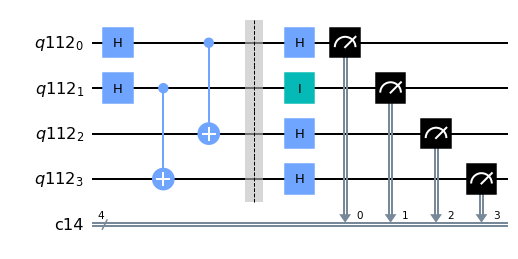

In [24]:
q = QuantumRegister(4) 
c = ClassicalRegister(4) 
qc = QuantumCircuit(q, c) 
qc.h(q[0])
qc.h(q[1])
qc.cx(q[1],q[3])
qc.cx(q[0],q[2])
qc.barrier()
U(qc,1,0,1) 
V(qc,1,2,3)
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)
qc.measure(3,3)
qc.draw(output='mpl')

In [216]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, optimization_level=3, shots=8192).result().get_counts()
expected_states = check_result(results, 1, 1)
state_accuracy = get_state_accuracy(results,expected_states,8192)
print("Accuracy: "+state_accuracy)

Accuracy: 100.0%


#### Evidently, the results of the mathematical calculation match those of the circuit and a win rate of 100% is achieved!

------------------------------------------------------------------------------------------------------------------------------------------------------------------
To reproduce these operations for other configurations, it is recommended to use the Unitary simulator - follow this simple guide:

1. Install "pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src"

2.  Create new Cell & Fill:
from qiskit_textbook.tools import array_to_latex;
result = execute(qc, Aer.get_backend('unitary_simulator')).result().get_unitary(qc);
array_to_latex(result, pretext="\\text{Circuit = }\n");
------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Circuit Performance on Real Quantum Devices

#### Thus far all executions of the Quantum circuits were performed on ideal quantum simulators, rather than actual quantum hardware. Real quantum computers have noise, decoherence and other periphery hardware issues, which can reduce the performance and fidelity of the executions. Hence, in order to ascertain the actucal performance and not only the theoretical we will execute our circuit on real quantum computers as well as simulators of real computers that include the above mentioned errors alike. 

#### We start off with the non-ideal simulators of the real quantum computers, so called FakeDevices. The use of FakeVigo, simualating the quantum Computer Vigo yields the following results.

In [10]:
job = execute(magicsquare_circuit, FakeVigo(), optimization_level=3, shots=8192) # run the job simulation
results = job.result().get_counts()
expected_states = check_result(results, alpha, beta)
state_accuracy = get_state_accuracy(results,expected_states,8192)
print(state_accuracy)

95.27587890625%


#### Now in order to evaluate the performance of real devices we select the ibmq_athens computer to benchmark the MPG. Please note that you will have to add your own API token from the IBM Quantum website (https://quantum-computing.ibm.com) so that this cell executes

In [53]:
IBMQ.save_account('YOUR_API_TOKEN') # retrieve from your IBM-Account: https://quantum-computing.ibm.com

configrc.store_credentials:WARNING:2021-03-15 09:28:25,642: Credentials already present. Set overwrite=True to overwrite.


In [392]:
# load IBM Quantum Experience account 
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q') # get provider

In [393]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [394]:
backend = provider.get_backend("ibmq_athens")

In [395]:
job = execute(magicsquare_circuit, backend,optimization_level=3, shots=8192) # run the job simulation with the highest compilter optimsation
results = job.result().get_counts()
expected_states = check_result(results, alpha, beta)
state_accuracy = get_state_accuracy(results,expected_states,8192)

In [396]:
state_accuracy

'96.69189453125%'

#### As shown above, the MPG circuit outperforms the classical circuit by about 7.8% (88.89% vs. 96.69%) on a real, noisy, quantum computer.